In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

# 1. Convolutions

## 1.2 Linear filter
$$x \circ f[k] = \sum x [k+i]f[i]$$

### 1.2.1 Python example: linear filters using scipy

In [2]:
linear_kernel = [1,-1,0]
signal = np.array([2,3,1,1,4])
print('Original signal:{}'.format(signal), "\n")
for filter_method in ['full', 'same', 'valid']:
    result = np.convolve(signal, linear_kernel, mode=filter_method)
    print(str(filter_method)+": {}".format(result))

Original signal:[2 3 1 1 4] 

full: [ 2  1 -2  0  3 -4  0]
same: [ 1 -2  0  3 -4]
valid: [-2  0  3]


### 1.2.2 Python example: Circulant image gradient

In [3]:
def circulant(x):
    circ = list([])
    for i in range(len(x)):
        circ.append(x[i]-x[(i-1)])
    print(circ)
circulant(signal)

[-2, 1, -2, 0, 3]


### 1.2.3 Python example: linear filters with matrices

In [4]:
x= np.random.randint(10, size=(3,3))

kernel_h = [[1,-1,0]] 
kernel_v = [[1],[-1],[0]]
print("Original matrix: \n{}".format(x))
print("Horizontal gradient: \n{}".format(convolve2d(x,kernel_h, mode='same', boundary='wrap')))
print("Vertical gradient: \n{}".format(convolve2d(x,kernel_v, mode='same', boundary='wrap')))

Original matrix: 
[[0 4 0]
 [8 3 5]
 [8 0 9]]
Horizontal gradient: 
[[ 4 -4  0]
 [-5  2  3]
 [-8  9 -1]]
Vertical gradient: 
[[ 8 -1  5]
 [ 0 -3  4]
 [-8  4 -9]]


# 2. Discrete gradient 2D

## 2.1 Total variation (TV)
$$TV(X) = |\nabla x|= \sum|x_{i+1}-x_i|$$

- All pairwise coordinate differences

Computation:
1. Convolve with stencil [0,1,-1]
- Take absolute value
- Take sum

## 2.2 Total variation-2d
- Total variation measures how many edges there are in your image

$$(\nabla x)_ij = (x_{i+1,j}-x_{i,j}, x_{i,j+1}-x_{i,j})$$

Anisotropic $|(\nabla x)_ij| = |x_{i+1,j}-x_{i,j}|+ |x_{i,j+1}-x_{i,j}|$

Isotropic $||(\nabla x)_ij|| = \sqrt{(x_{i+1,j}-x_{i,j})^2+ (x_{i,j+1}-x_{i,j})^2}$
- 1-L is not isotropic
- 2-L is isotropic- you can rotate and it won't change

### 2.2.1 Python example: anisotropic vs isotropic

In [5]:
np.random.seed(0)
x = np.random.randint(10, size=(3,3)) #3x3 matrix
x

array([[5, 0, 3],
       [3, 7, 9],
       [3, 5, 2]])

In [6]:
def anisotropic(x):
    x_diff = abs(x - np.roll(x, -1, axis=1))
    y_diff = abs(x - np.roll(x, -1, axis=0))
    return np.sum(x_diff+y_diff)
print("Non rotated solu: {}".format(anisotropic(x)))
print('Rotated solus:')
for rotation in ['rot90', 'fliplr','flipud']:
    rotate = eval("np."+rotation+"(x)")
    solu = anisotropic(rotate)
    print(solu)

Non rotated solu: 60
Rotated solus:
60
60
60


In [7]:
def isotropic(x):
    x_diff = (x - np.roll(x, -1, axis=1))**2
    y_diff = (x - np.roll(x, -1, axis=0))**2
    isotropic = np.sum(np.sqrt(x_diff+y_diff))
    return isotropic
print("Non rotated solu: {}".format(np.round(isotropic(x),3)))
print('Rotated solus:')
for rotation in ['rot90', 'fliplr','flipud']:
    rotate = eval("np."+rotation+"(x)")
    solu = np.round(isotropic(rotate),3)
    print(solu)

Non rotated solu: 45.447
Rotated solus:
46.675
46.675
46.366


# 3. Computing Total variation on images

## 3.1 Python example: Computing TV on images
### 3.1.1. Color images are represented with three matrixs: Row, Height, Color

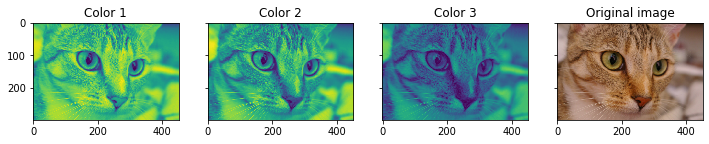

In [8]:
from skimage import data, color, img_as_float
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 6),sharex=True, sharey=True)
for i in range(0,3):
    ax[i].imshow(data.chelsea()[:,:,i])
    ax[i].set_title('Color '+str(i+1))
ax[3].imshow(data.chelsea()[:,:,:])
ax[3].set_title('Original image');

### 3.1.2.1 Isotropic TV

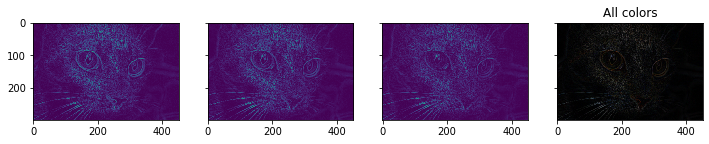

In [9]:
photo = img_as_float(data.chelsea())
def isotropic_im(x):
    x_diff = (x - np.roll(x, -1, axis=1))**2
    y_diff = (x - np.roll(x, -1, axis=0))**2
    isotropic = np.sqrt(x_diff+y_diff)
    return isotropic
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 6),sharex=True, sharey=True)
for i in range(0,3):
    ax[i].imshow((isotropic_im(photo[:,:,i])))
ax[3].imshow(isotropic_im(photo[:,:,:]))
ax[3].set_title('All colors');

### 3.1.2.2 Total variation

Code reference: Crowson, Katherine (2020) denoise.py https://gist.github.com/crowsonkb/ddf8167359be4ba2aa34835aa207e241

In [10]:
def tv_norm(x):
    """Computes the total variation norm and its gradient. From jcjohnson/cnn-vis."""
    x_diff = x - np.roll(x, -1, axis=1)
    y_diff = x - np.roll(x, -1, axis=0)
    grad_norm2 = x_diff**2 + y_diff**2
    norm = np.sum(np.sqrt(grad_norm2))
    dgrad_norm = 0.5 / np.sqrt(grad_norm2)
    dx_diff = 2 * x_diff * dgrad_norm
    dy_diff = 2 * y_diff * dgrad_norm
    grad = dx_diff + dy_diff
    grad[:, 1:, :] -= dx_diff[:, :-1, :]
    grad[1:, :, :] -= dy_diff[:-1, :, :]
    return norm, grad

/Users/corybaird/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/Users/corybaird/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in multiply
  
/Users/corybaird/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


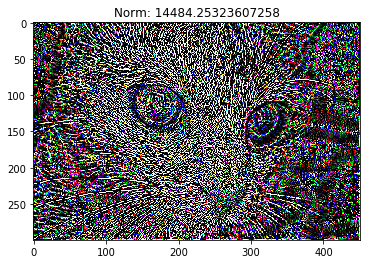

In [11]:
norm, grad = tv_norm(photo)
plt.imshow(grad)
plt.title("Norm: {}".format(str(norm)));

### 3.1.3 Linear filters and convoluations


Linear filters:
   - x-stencil = (-1,1,0)
   - y-stencil = (-1,1,0)
   
Linear convolutions:
   - x-kernel = (0,1,-1)
   - y-kernel = (0,1,-1)
   
- Take stencil lay down on image and compute inner product you are using a linear filter
- Convolving flip horizontally and vertically then lay down stencil on image.
    - Convolution net is actually a linear filter

#### 3.1.3.1 Image gradients using linear filter and convlutions

#### 3.1.3.1.1 Linear filter

Code reference: University of Maryland, Advanced Numerical Optimization (2020). hmwk2_more_linalg_sols.ipynb https://www.cs.umd.edu/~tomg/cmsc764_2020/

In [12]:
#Linear filter
kernel_h = [[1,-1,0]] 
kernel_v = [[1],[-1],[0]]
def gradh(x):
    """Discrete gradient/difference in horizontal direction"""
    return convolve2d(x,kernel_h, mode='same', boundary='wrap')
def gradv(x):
    """Discrete gradient/difference in vertical direction"""
    return convolve2d(x,kernel_v, mode='same', boundary='wrap')

def grad2d(x):
    return np.stack([gradh(x),gradv(x)])

#### 3.1.3.1.2 FFT 
Code reference: University of Maryland, Advanced Numerical Optimization (2020). hmwk2_more_linalg_sols.ipynb https://www.cs.umd.edu/~tomg/cmsc764_2020/


FFT diagnonalizes convolution matrices


$$K_x = F^T DF_x$$

Where:
- $D=$ diagonal matrix
- $F^T ,F=$ orthogonal matrices

D calculation:
- FFT of backward filter stencil

Condition number of FFT
- Poorly conditioned


In [13]:
#FFT convolution
from numpy.fft import fft2, ifft2
def gradh_fft(x):
    #convolve with the FLIPPED stencil to get the linear filtering we want 
    fft_kernel_h = np.zeros(x.shape) 
    fft_kernel_h[0,0] = -1
    fft_kernel_h[0,-1] = 1
    #Diagonal matrix
    Fk = fft2(fft_kernel_h)
    # Use the eigen-decomposition to convolve the stencil with X, and get the differences in the horizontal direction.
    Fx = fft2(x)
    return ifft2(Fx*Fk)
def gradv_fft(x):
    #convolve with the FLIPPED stencil to get the linear filtering we want 
    fft_kernel_v = np.zeros(x.shape) 
    fft_kernel_v[0,0] = -1
    fft_kernel_v[-1,0] = 1
    #Diagonal matrix
    Fk = fft2(fft_kernel_v) 
    # Use the eigen-decomposition to convolve the stencil with X, and get the differences in the horizontal direction.
    Fx = fft2(x) 
    return ifft2(Fx*Fk)

#### 3.1.3.2 Plot Kernal and FFT convolutions

Are horizontal FFT and gradient equal? True
Are vertical FFT and gradient equal? True


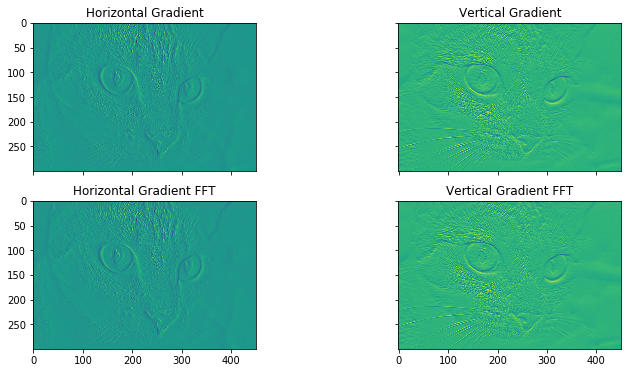

In [14]:
color1 = photo[:,:,0]
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 6),sharex=True, sharey=True)
ax[0,0].imshow(gradh(color1))
ax[0,0].set_title('Horizontal Gradient')
ax[0,1].imshow(gradv(color1))
ax[0,1].set_title('Vertical Gradient')
ax[1,0].imshow(np.real(gradh_fft(color1)))
ax[1,0].set_title('Horizontal Gradient FFT')
ax[1,1].imshow(np.real(gradv_fft(color1)))
ax[1,1].set_title('Vertical Gradient FFT');
print("Are horizontal FFT and gradient equal? {}".format((np.round(np.real(gradh_fft(color1)),4) == np.round(gradh(color1),4)).all(1)[0]))
print("Are vertical FFT and gradient equal? {}".format((np.round(np.real(gradv_fft(color1)),4) == np.round(gradv(color1),4)).all(1)[0]))

### 3.1.4 Compute the divergence

#### 3.1.4.1 Divergence function

Potential solution: https://github.com/dbhadra/CMSC764-Advanced-Numerical-Optimization/blob/99f8196aa29881b28f07224c9d4d9e7f602320c4/Homework-2/hmwk2_results.tex

#### 3.1.4.2 Plot divergence

## 3.2 Total variation denoising

Blurry
$$\lambda ||\nabla x||^2 +||x-f||^2$$

Crispier
$$\lambda |\nabla x| + \frac{1}{2}||x-f||^2$$

- 2-L is a bad prior for edges
    - This is because it penalizes outliers
        - $dark \rightarrow light$ has outliers
        

### 3.2.1 Python example: TV denoising
Code reference: Denoising a picture Sci-kit image tutorial [Link](https://scikit-image.org/docs/dev/auto_examples/filters/plot_denoise.html)

In [15]:
import matplotlib.pyplot as plt

from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)
from skimage import data, img_as_float
from skimage.util import random_noise


Estimated Gaussian noise standard deviation = 0.1510038462668498


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


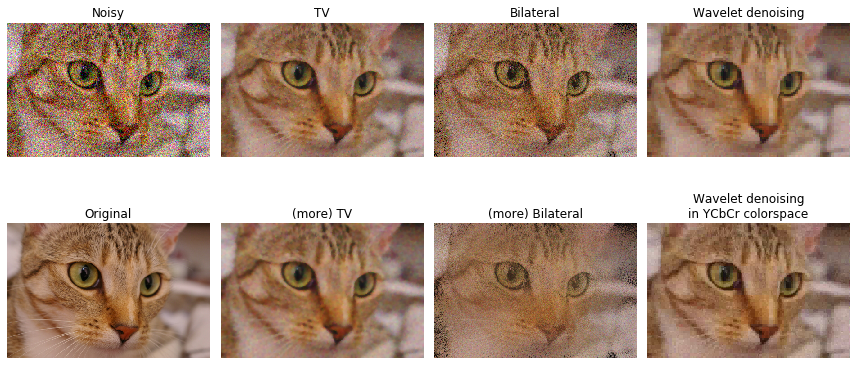

In [16]:
original = img_as_float(data.chelsea())
sigma = 0.155
noisy = random_noise(original, var=sigma**2)
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12, 6),
                       sharex=True, sharey=True)

plt.gray()

# Estimate the average noise standard deviation across color channels.
sigma_est = estimate_sigma(noisy, multichannel=True, average_sigmas=True)
# Due to clipping in random_noise, the estimate will be a bit smaller than the
# specified sigma.
print(f"Estimated Gaussian noise standard deviation = {sigma_est}")

ax[0, 0].imshow(noisy)
ax[0, 0].axis('off')
ax[0, 0].set_title('Noisy')
ax[0, 1].imshow(denoise_tv_chambolle(noisy, weight=0.1, multichannel=True))
ax[0, 1].axis('off')
ax[0, 1].set_title('TV')
ax[0, 2].imshow(denoise_bilateral(noisy, sigma_color=0.05, sigma_spatial=15,
                multichannel=True))
ax[0, 2].axis('off')
ax[0, 2].set_title('Bilateral')
ax[0, 3].imshow(denoise_wavelet(noisy, multichannel=True, rescale_sigma=True))
ax[0, 3].axis('off')
ax[0, 3].set_title('Wavelet denoising')

ax[1, 1].imshow(denoise_tv_chambolle(noisy, weight=0.2, multichannel=True))
ax[1, 1].axis('off')
ax[1, 1].set_title('(more) TV')
ax[1, 2].imshow(denoise_bilateral(noisy, sigma_color=0.1, sigma_spatial=15,
                multichannel=True))
ax[1, 2].axis('off')
ax[1, 2].set_title('(more) Bilateral')
ax[1, 3].imshow(denoise_wavelet(noisy, multichannel=True, convert2ycbcr=True,
                                rescale_sigma=True))
ax[1, 3].axis('off')
ax[1, 3].set_title('Wavelet denoising\nin YCbCr colorspace')
ax[1, 0].imshow(original)
ax[1, 0].axis('off')
ax[1, 0].set_title('Original')

fig.tight_layout()

plt.show()

# 4. Fourier


## 4.1 Fourier series

- The fourier series is how to write your function in an orthogonal basis of sines and cosines
- Useful for approximations
    - Allows us to truncate in order to approximate functions

### Sum of 2 pi periodic
$$\langle f(x), g(x)\rangle =  \int^b_a f(x) g(x) dx \\
f(x) = \frac{A_0}{2}+ \sum^{\infty}_{k=1} (A_k cos(Kx)+B_ksin(Kx))\\
A_k = \frac{1}{\pi} \int^{\infty}_{-\infty} f(x) cos(Kx) dx = \frac{1}{||cos(Kx)||^2}\langle f(x), \text{cos} (Kx)\rangle \\
B_k = \frac{1}{\pi} \int^{\infty}_{-\infty} f(x) sin(Kx) dx = \frac{1}{||sin(Kx)||^2}\langle f(x), \text{sin} (Kx)\rangle
$$

### Sum of 0 to L

$$\langle f(x), g(x)\rangle =  \int^b_a f(x) g(x) dx \\
f(x) = \frac{A_0}{2}+ \sum^{\infty}_{k=1} \Big(A_k cos(\frac{2\pi Kx}{L})+B_k sin(\frac{2\pi Kx}{L}\Big)\\
A_k = \frac{2}{L} \int^{L}_{0} f(x) cos(\frac{2\pi Kx}{L}) dx  \\
B_k = \frac{2}{L} \int^{L}_{0} f(x) sin(\frac{2\pi Kx}{L}) dx 
$$

## 4.2 Complex Fourier Series

- Cosines and sines form an orthogonal basis in which we can represent all functions
- Infinitely many directions in the basis


$$\langle f(x), g(x)\rangle =  \int^\pi_{-\pi} f(x) g(x) dx \\
\\
f(x) =\sum^{\infty}_{k=-\infty}c_k e^{iKx}= \sum^{\infty}_{k=-\infty} (\alpha_k+i\beta_k) cos(Kx)+i \text{sin}(Kx) \\
\\
e^{iKx}=cos(Kx)+i \text{sin}(Kx)=\psi_k
$$

Show vectors are orthogonal

$$\langle \psi_j, \psi_k\rangle = \int^{\pi}_{-\pi} e^{ijx}e^{-ikx} dx = \frac{1}{i(j-k)} \Big[e^{i(j-k)x} \Big]^\pi_{-\pi} 
\\
=\begin{cases} 0 \ \ \ \ \  \text{if j=k} \\ 2\pi  \ \ \ \text{if j=k} \end{cases}
$$

### 4.2.1 Python example: Fourier series

Code reference: https://github.com/dynamicslab/databook_python/blob/master/CH02/CH02_SEC01_1_FourierSines.ipynb

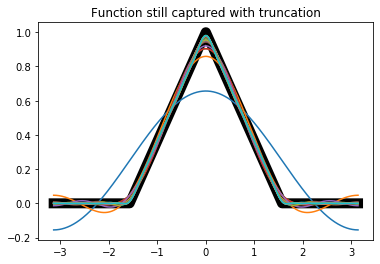

In [21]:
# Define domain
dx = 0.001
L = np.pi
x = L * np.arange(-1+dx,1+dx,dx)
n = len(x)
nquart = int(np.floor(n/4))

# Define hat function
f = np.zeros_like(x)
f[nquart:2*nquart] = (4/n)*np.arange(1,nquart+1)
f[2*nquart:3*nquart] = np.ones(nquart) - (4/n)*np.arange(0,nquart)

#Plotting hat function
fig, ax = plt.subplots()
ax.plot(x,f,'-',color='k',LineWidth=10)

A0 = np.sum(f * np.ones_like(x)) * dx
fFS = A0/2 #Cosine of zero

A = np.zeros(20)
B = np.zeros(20)
for k in range(20):
    A[k] = np.sum(f * np.cos(np.pi*(k+1)*x/L)) * dx # Inner product
    B[k] = np.sum(f * np.sin(np.pi*(k+1)*x/L)) * dx
    fFS = fFS + A[k]*np.cos((k+1)*np.pi*x/L) + B[k]*np.sin((k+1)*np.pi*x/L)
    ax.plot(x,fFS,'-')
plt.title('Function still captured with truncation');

# 4.3 Fourier Transform

- Fourier transform takes L to infity. No longer periodic.
- Take omega to the limit and you get an integral

$$f(x)= \sum^\infty_{k=-\infty} C_k e^{ik \pi x / L } $$



$$ f(x) = \underset{\Delta \omega\rightarrow 0}{lim} \sum^\infty_{k=-\infty}\frac{\Delta w}{2 \pi} \int^{\pi/\delta\omega}_{\pi/\delta\omega} f(\xi) e^{-i k\Delta\omega \xi} d \xi e^{ik\Delta \omega x} \\
\\
=  \int^\infty_{-\infty}\frac{1}{2\pi} \int^\infty_{-\infty}f(\xi) e^{-i\omega \xi}d\xi e^{i\omega x} d\omega
$$

$$\hat{f} = F(f(x))=\int_{-\infty}^\infty(x)e^{-i\omega x}dx$$


#### Alternative form

$$\hat{x}_k e ^{-i 2\pi k n/n}\\
\hat{x}_k = \langle x, F_k\rangle$$

- The k-th entry in the Fourier transform, take signal x, inner product of kth row in fourier
    - This is complex
    


## 4.4 Convolution Theorem

Convolution = muliplication in Fourier domain

$$x * y = F^T (F_X \dot F_y)$$

$$(f*g)= \int_{-\infty}^\infty f(x-\xi)g(\xi)d\xi$$

$$F(f*g)= F(f)F(g)=\hat f\hat g$$

$$F^{-1}(\hat f\hat g)(x) = \frac{1}{2\pi} \int_{-\infty}^\infty\hat{f}(\omega) \hat g (\omega) e^{i\omega x} d\omega$$



## 4.5 Parseval's theorem

- Fourier is a linear operator

$$F(\alpha f(x)+\beta g(x)) = \alpha F(f) +\beta F(g)$$

#### Parseval's Thm
- If we zero out (truncate) small coefficients then we can still capture most of the function


$$\int_{-\infty}^\infty |\hat f (\omega)|^2 du = 2\pi \int_{-\infty}^\infty |\hat f (\omega)|^2dx $$

## 4.6 Discrete Fourier Transform

- If we have data vector we can compute fourier series using discrete fourier transform
- DFT is a matrix
    - Multiply by data vector to get fourier transform
- Fourier transform is complex number
- Phase between cosine and sine
    

### 4.6.1 Python example: DFT

In [59]:
def dft(matrix):
    w = np.exp(-1j * 2 * np.pi / np.shape(matrix)[0])
    DFT = np.zeros((np.shape(matrix)[0], np.shape(matrix)[1]))
    for i in range(np.shape(matrix)[0]):
        for k in range(np.shape(matrix)[1]):
            DFT[i,k] = w**(i*k)
    DFT = np.real(DFT)
    return DFT

/Users/corybaird/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  import sys


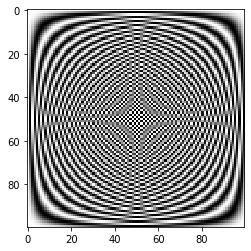

In [60]:
#Plot identity matrix
plt.imshow(dft(np.eye(100)));

#Identical to fft but slower
#F = np.fft.fft(np.eye(100))  
#plt.imshow(np.real(F));

## 4.7 Fast Fourier Transform

- Exploits symmatries in DFT to re-write problem as efficient matrix multiplications of smaller size
- Rearrange vector into evens and odds
- We can continue to iterate and shrink DFT matrix
    - $F_{1024}\rightarrow F_{512}\rightarrow \dots F_{2}$


$$n = 2^{10}=1024\\
\hat{f} = F_{1024} \ \ f = \begin{bmatrix} I_{512} - D_{512} \\ I_{512}- D_{512}\end{bmatrix} \begin{bmatrix} F_{512} & 0 \\ 0&F_{512}  \end{bmatrix} \begin{bmatrix} F_{even} \\ F_{odd}  \end{bmatrix}
$$ 


FFT diagnonalizes convolution matrices


$$K_x = F^T DF_x$$

Where:
- $D=$ diagonal matrix
- $F^T ,F=$ orthogonal matrices

### D calculation:
- FFT of backward filter stencil

### Condition number of FFT
- Poorly conditioned


### 4.7.1 Python example: Denoising with FFT

Reference:  https://github.com/dynamicslab/databook_python/tree/master/CH02

In [117]:
# Create a simple signal with two frequencies
dt = 0.001
t = np.arange(0,1,dt)
f = np.sin(2*np.pi*50*t) + np.sin(2*np.pi*120*t) # Sum of 2 frequencies
f_clean = f
f = f + 2.5*np.random.randn(len(t))              # Add some noise

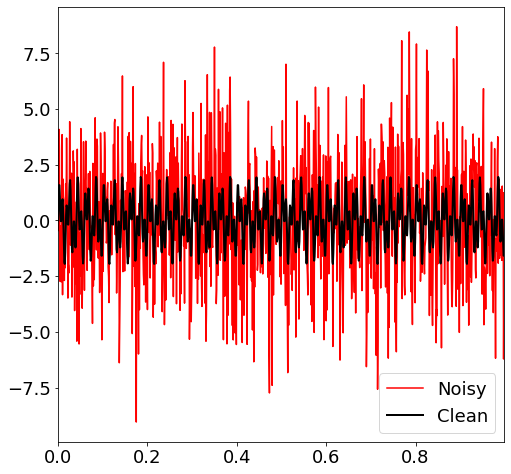

In [118]:
plt.plot(t,f,color='r',LineWidth=1.5,label='Noisy')
plt.plot(t,f_clean,color='k',LineWidth=2,label='Clean')
plt.xlim(t[0],t[-1])
plt.legend();

In [111]:
## Compute the Fast Fourier Transform (FFT)
n = len(t)
fhat = np.fft.fft(f,n)                     # Compute the FFT
PSD = fhat * np.conj(fhat) / n             # Power spectrum (power per freq)
freq = (1/(dt*n)) * np.arange(n)           # Create x-axis of frequencies in Hz
L = np.arange(1,np.floor(n/2),dtype='int') # Only plot the first half of freqs

In [112]:
## Use the PSD to filter out noise
indices = PSD > 100       # Find all freqs with large power
PSDclean = PSD * indices  # Zero out all others
fhat = indices * fhat     # Zero out small Fourier coeffs. in Y
ffilt = np.fft.ifft(fhat) # Inverse FFT for filtered time signal

/Users/corybaird/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/corybaird/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/corybaird/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


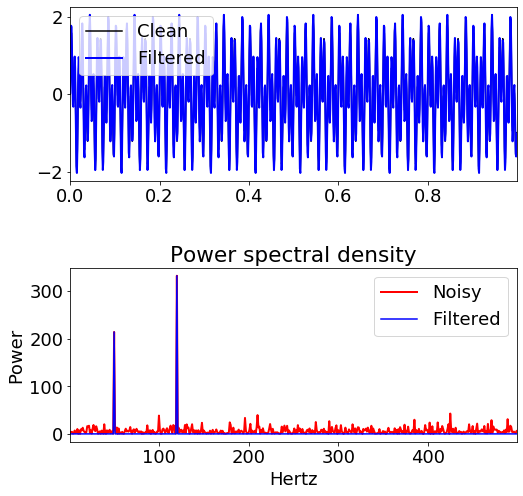

In [119]:
## Plots
fig,axs = plt.subplots(2,1)

plt.sca(axs[0])
plt.plot(t,f_clean,color='k',LineWidth=1.5,label='Clean')
plt.plot(t,ffilt,color='b',LineWidth=2,label='Filtered')
plt.xlim(t[0],t[-1])
plt.legend()

plt.sca(axs[1])
plt.plot(freq[L],PSD[L],color='r',LineWidth=2,label='Noisy')
plt.plot(freq[L],PSDclean[L],color='b',LineWidth=1.5,label='Filtered')
plt.xlim(freq[L[0]],freq[L[-1]])
plt.xlabel('Hertz')
plt.ylabel('Power')
plt.title('Power spectral density')
plt.legend()
fig.subplots_adjust(hspace=.5)

plt.show()

### 4.7.2 Python example: Computing derivatives with FFT

Reference:  https://github.com/dynamicslab/databook_python/tree/master/CH02

/Users/corybaird/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/corybaird/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/corybaird/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


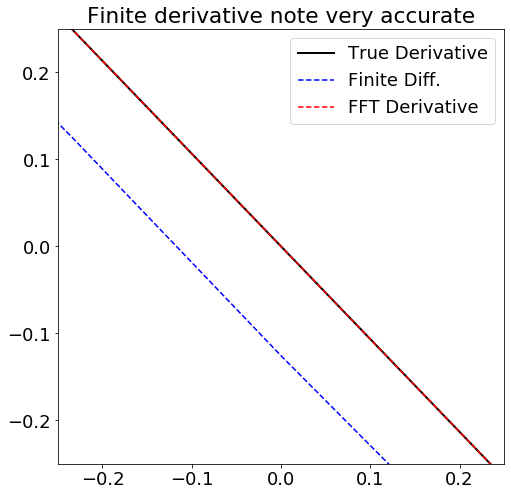

In [125]:
n = 128
L = 30
dx = L/n
x = np.arange(-L/2,L/2,dx,dtype='complex_')

f = np.cos(x) * np.exp(-np.power(x,2)/25) # Function
df = -(np.sin(x) * np.exp(-np.power(x,2)/25) + (2/25)*x*f) # Derivative--Chain rule

## Approximate derivative using finite difference
dfFD = np.zeros(len(df),dtype='complex_')
for kappa in range(len(df)-1): #Wave number (spatial frequencies)
    dfFD[kappa] = (f[kappa+1]-f[kappa])/dx
    
dfFD[-1] = dfFD[-2]

## Derivative using FFT (spectral derivative)
fhat = np.fft.fft(f)
kappa = (2*np.pi/L)*np.arange(-n/2,n/2) 
kappa = np.fft.fftshift(kappa) # Re-order fft frequencies
dfhat = kappa * fhat * (1j)
dfFFT = np.real(np.fft.ifft(dfhat))

## Plots
plt.plot(x,df.real,color='k',LineWidth=2,label='True Derivative')
plt.plot(x,dfFD.real,'--',color='b',LineWidth=1.5,label='Finite Diff.')
plt.plot(x,dfFFT.real,'--',color='r',LineWidth=1.5,label='FFT Derivative')
plt.legend()
plt.title("Finite derivative note very accurate")
plt.xlim([-.25, .25])
plt.ylim([-.25, .25])
plt.show()